<a href="https://colab.research.google.com/github/ftxsilva/Data-Challenge-CAPGEMINI/blob/master/Hackathon_exploratory_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hackathon Supaero - Restaurants ratings prediction

Predict Yelp restaurants ratings from associated reviews, data about users and restaurants# 0. Packages

In [ ]:
# utiliser google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 0. Packages

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
!pip install lime
from lime.lime_text import LimeTextExplainer
import string
import seaborn as sns
import matplotlib.pyplot as plt

     |████████████████████████████████| 276kB 4.8MB/s 
  Created wheel for lime: filename=lime-0.1.1.37-cp36-none-any.whl size=284277 sha256=0a3d0b413ab88863011f45f8c8bd18a2400c0ef1b994205d563e16ff2c8f3ef2
  Stored in directory: /root/.cache/pip/wheels/c1/38/e7/50d75d4fb75afa604570dc42f20c5c5f5ab26d3fbe8d6ef27b
  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12074 sha256=9869cd92f3eee48db03a90b079fd4312e24d7b7cb228c8e10de14097b20be046
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built lime progressbar


In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload() # Upload the file from your computer here 
               # (you have to download it at https://www.kaggle.com/<Your_Account>/account at the API Section)
!cp kaggle.json ~/.kaggle/
#!kaggle competitions submit -c restaurants-ratings-prediction -f [FILE PATH] -m "[CUSTOM MESSAGE]"

# 1. Data

In [ ]:
df = pd.read_csv("/content/drive/My Drive/Hackathon-Capgemini/data/train_set.csv")
df_test = pd.read_csv("/content/drive/My Drive/Hackathon-Capgemini/data/test_set.csv")

#df = df.sample(10000)
#df_test = df_test.sample(5000)

In [ ]:
df.head(2)

,review_id,review,rating,binary_target,user_id,business_id,useful_review,funny_review,cool_review,name_restaurant,address,city,state,postal_code,latitude,longitude,review_count_restaurant,is_open,name_user,review_count_user,yelping_since,useful_user,funny_user,cool_user,elite,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_photos
0,1,"Like walking back in time, every Saturday morn...",4.0,1,FIk4lQQu1eTe2EpzQ4xhBA,8mIrX_LrOnAqWsB5JrOojQ,0.0,0.0,0.0,Pinball Hall Of Fame,1610 E Tropicana Ave,Las Vegas,NV,89119.0,36.101449,-115.130511,1258.0,1.0,Carol,866.0,2010-08-26 22:09:14,1635.0,314.0,726.0,"2011,2012,2013,2014,2015,2016,2017,2018",63.0,4.16,18.0,10.0,3.0,2.0,2.0,29.0,26.0,53.0,53.0,15.0
1,2,The food is always good and the prices are rea...,4.0,1,3CJUJILq7CLHk_9OrvpvQg,I4Nr-MVc26qWr08-S3Q1ow,0.0,0.0,0.0,Greenberg's Deli,3790 Las Vegas Blvd S,Las Vegas,NV,89136.0,36.102379,-115.174547,333.0,1.0,Ralph,54.0,2014-03-26 00:29:39,27.0,2.0,4.0,NaN,0.0,3.05,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
df = df.dropna(subset=["review"])
df_test = df_test.dropna(subset=["review"])

In [ ]:
restau_id = df_test[df_test.name_restaurant=='Mon Ami Gabi'].business_id.unique()[0]
restau_id

'4JNXUYY8wbaaDmk3BPzlWw'

# 4. Feature Engineering

Dans cette partie, la démarche a été d'analyser toutes les variables une par une, de manière à comprendre quelles variables doivent être maintenues, quelles variables doivent être utilisées pour faire du feature engineering et quelles variables peuvent simplement être éliminées.

- review_id: l'identifiant du review par soi même n'est pas intéréssant. On l'élimine.

- user_id et name_user: l'identifiant du user ou son nom par soi même n'est pas intéréssant. Il pourrait être intéréssant d'utiliser l'id pour faire quelques nouvelles moyennes pour cet id apart la moyenne d'étoiles. Par exemple obtenir la moyenne de compliments que la personne qui a laissé le review obtient normalement, ou encore la différence entre les copmliments obtenus dans ce review et la moyenne de compliments obtenus par l'utilisateur. Mais on décide d'éliminer ces 2 variables.

- business_id et name_restaurant: on élimine ces variables parce que dans le dataset de test on n'a que le restaurant 'Mon Ami Gabi', qui n'est même pas présent dans le dataset d'entraînement. Dans la partie 2 il peut être intéressant de regarder les restaurants bons pour donner des avis.

- address, city, state, postal_code, latitude, longitude: tous ces variables représentent la localization du restaurant em LV. Ainsi, on va faire du feature engineering, faisant un clustering pour créér une variable qui donne une note entre 1 et 3 pour la localization du restaurant. Et on élimine ces 5 variables.

- review_count_user et yelping_since: on peut peut-être utiliser ces variables pour créer une feature 'antiquité'. Important pour la deuixième partie, pour donner plus d'importance aux avis de ceraines personnes.

- yelping_since: la date par elle même n'ajoute pas beaucoup d'info. Ce qui est intéressant est de savoir l'antiquité du client dans le site Yelp. On va convertir 'yelping_since' en 'antiquite'.

- elite: au lieu de conserver la liste complète, on met dans cette variable tout simplement le nombre d'années que la personne a fait partie de la brigade de Yelp. Pour la deuixième partie, il peut être intéressant de donner plus d'importance aux avis en fonction de cette valeur.

- les 10 compliments finaux: il peut être intéressant d'obtenir la moyenne de compliments obtenus par l'utilisateur, et peut-être la comparer avec les valeurs de la review

Le reste des features sont laissées telles qu'elles sont.

## 4.2 Drop features

In [ ]:
cols = df.columns
print(cols)

Index(['review_id', 'review', 'rating', 'binary_target', 'user_id',
       'business_id', 'useful_review', 'funny_review', 'cool_review',
       'name_restaurant', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'review_count_restaurant', 'is_open',
       'name_user', 'review_count_user', 'yelping_since', 'useful_user',
       'funny_user', 'cool_user', 'elite', 'fans', 'average_stars',
       'compliment_hot', 'compliment_more', 'compliment_profile',
       'compliment_cute', 'compliment_list', 'compliment_note',
       'compliment_plain', 'compliment_cool', 'compliment_funny',
       'compliment_photos'],
      dtype='object')


In [ ]:
#drop_columns = ['review_id', 'name_user', 'name_restaurant', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude']

#df.drop(drop_columns, axis=1, inplace = True)
#df_test.drop(drop_columns, axis=1, inplace = True)

In [ ]:
print('\nColumns with null values in train dataframe:\n', df.isnull().sum())
print("-"*30)
print('\nColumns with null values in test dataframe:\n', df_test.isnull().sum())


Columns with null values in train dataframe:
 review                          0
rating                         15
binary_target                   0
user_id                        15
business_id                    15
useful_review                  15
funny_review                   15
cool_review                    15
review_count_restaurant        15
is_open                        15
review_count_user              15
yelping_since                  15
useful_user                    15
funny_user                     15
cool_user                      15
elite                      933474
fans                           15
average_stars                  15
compliment_hot                 15
compliment_more                15
compliment_profile             15
compliment_cute                15
compliment_list                15
compliment_note                15
compliment_plain               15
compliment_cool                15
compliment_funny               15
compliment_photos              15
d

In [ ]:
cols_to_check = df.columns
df['is_na'] = df[cols_to_check].isnull().apply(lambda x: sum(x), axis=1) 

In [ ]:
df['is_na'].unique()

array([ 0,  1,  3,  2, 34])

In [ ]:
index_to_drop = [i for i, x in enumerate((df['is_na']>1).values) if x]
df.drop(index_to_drop, inplace = True)

In [ ]:
print('\nColumns with null values in train dataframe:\n', df.isnull().sum())
print("-"*30)
print('\nColumns with null values in test dataframe:\n', df_test.isnull().sum())


Columns with null values in train dataframe:
 review                          0
rating                          0
binary_target                   0
user_id                         0
business_id                     0
useful_review                   0
funny_review                    0
cool_review                     0
review_count_restaurant         0
is_open                         0
review_count_user               0
yelping_since                   0
useful_user                     0
funny_user                      0
cool_user                       0
elite                      933459
fans                            0
average_stars                   0
compliment_hot                  0
compliment_more                 0
compliment_profile              0
compliment_cute                 0
compliment_list                 0
compliment_note                 0
compliment_plain                0
compliment_cool                 0
compliment_funny                0
compliment_photos               0
i

## 4.1 Create new features

In [ ]:
#create new elite
df= df.assign(
  elite = df.elite.apply(lambda x: len(x.split(','))  if type(x)==str  else  0 )
)

df_test= df_test.assign(
  elite = df_test.elite.apply(lambda x: len(x.split(','))  if type(x)==str  else  0 )
)

In [ ]:
print(df['elite'].unique())
print(df_test['elite'].unique())

[ 8  0  3  2  7  1  5  4  9 10 12  6 11 13]
[ 0 13  5  7  4  1  6  2  9 10  3  8 11 12]


In [ ]:
from datetime import datetime

def get_antiquity_years_from_date(date_str):
  '''
  ex of date_str format: '2010-08-26 22:09:14'
  '''
  current_datetime = datetime.now()
  datetime_object = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')

  #deltatime given in format (days, seconds, miliseconds)
  datetime_difference = current_datetime - datetime_object

  days = datetime_difference.days
  years = days/365
  return years

In [ ]:
#create new yelping_since
df= df.assign(
    yelping_since = df.yelping_since.apply(lambda x: get_antiquity_years_from_date(x) )
)

df_test= df_test.assign(
    yelping_since = df_test.yelping_since.apply(lambda x: get_antiquity_years_from_date(x) )
)

In [ ]:
df.drop('is_na', axis = 1, inplace = True)

In [ ]:
print('\nColumns with null values in train dataframe:\n', df.isnull().sum())
print("-"*30)
print('\nColumns with null values in test dataframe:\n', df_test.isnull().sum())


Columns with null values in train dataframe:
 review                     0
rating                     0
binary_target              0
user_id                    0
business_id                0
useful_review              0
funny_review               0
cool_review                0
review_count_restaurant    0
is_open                    0
review_count_user          0
yelping_since              0
useful_user                0
funny_user                 0
cool_user                  0
elite                      0
fans                       0
average_stars              0
compliment_hot             0
compliment_more            0
compliment_profile         0
compliment_cute            0
compliment_list            0
compliment_note            0
compliment_plain           0
compliment_cool            0
compliment_funny           0
compliment_photos          0
dtype: int64
------------------------------

Columns with null values in test dataframe:
 review_id                  0
review                

# 3. Exploratory Analysis

In [ ]:
df.head(2)

,review,rating,binary_target,user_id,business_id,useful_review,funny_review,cool_review,review_count_restaurant,is_open,review_count_user,yelping_since,useful_user,funny_user,cool_user,elite,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_photos
0,"Like walking back in time, every Saturday morn...",4.0,1,FIk4lQQu1eTe2EpzQ4xhBA,8mIrX_LrOnAqWsB5JrOojQ,0.0,0.0,0.0,1258.0,1.0,866.0,9.586301,1635.0,314.0,726.0,8,63.0,4.16,18.0,10.0,3.0,2.0,2.0,29.0,26.0,53.0,53.0,15.0
1,The food is always good and the prices are rea...,4.0,1,3CJUJILq7CLHk_9OrvpvQg,I4Nr-MVc26qWr08-S3Q1ow,0.0,0.0,0.0,333.0,1.0,54.0,6.005479,27.0,2.0,4.0,0,0.0,3.05,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
df.describe()

In [ ]:
df_test.head(2)

,review_id,review,user_id,business_id,useful_review,funny_review,cool_review,name_restaurant,address,city,state,postal_code,latitude,longitude,review_count_restaurant,is_open,name_user,review_count_user,yelping_since,useful_user,funny_user,cool_user,elite,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_photos
0,1234157,Hard to beat this location for table side ente...,x5NpvWNS1cF_4bINIBPGzQ,4JNXUYY8wbaaDmk3BPzlWw,0,0,0,Mon Ami Gabi,3655 Las Vegas Blvd S,Las Vegas,NV,89109,36.112859,-115.172434,8348,1,Sharon,69,5.057534,22,10,15,0,1,4.47,1,0,0,0,0,0,0,0,0,0
1,1234158,"Sometimes, all a girl needs is a great steak.\...",m5cBT7OYfn0HM0d-RCsdZQ,4JNXUYY8wbaaDmk3BPzlWw,7,6,5,Mon Ami Gabi,3655 Las Vegas Blvd S,Las Vegas,NV,89109,36.112859,-115.172434,8348,1,Miika,1707,13.706849,9059,6281,7867,13,412,3.90,1649,167,95,139,36,473,906,1542,1542,422


In [ ]:
df_test.describe()

In [ ]:
df_test.shape

(8570, 35)

In [ ]:
df.shape

(1234155, 38)

### Let's study our consumer database

In [ ]:
clients_restau = set(df_test.user_id.values) #we have all our clientele
print("Number of our clients: {}".format(len(clients_restau))) #so we find that there are clients who went twice or more 
#[(221) visits to account for]

Number of our clients: 8349


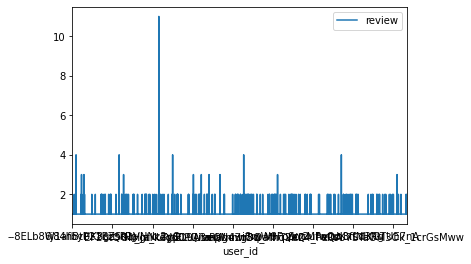

In [ ]:
#lets see who are the clients who visited at least twice
df_test.groupby('user_id')[['review']].count().plot()

In [ ]:
freq_clients = df_test.groupby('user_id')[['review']].count()
freq_clients = freq_clients[freq_clients.review>2] #
freq_clients.sort_values('review', ascending=False).head(3) #we have some interesting clients who came 4 times or more

,review
user_id,
F_5_UNX-wrAFCXuAkBZRDw,11
-h3OxE2YbWzFXVkBhYtJTw,4
7xQ5DkRxO4DfG59H1Xbw-g,4


In [ ]:
freq_clients.index[0]
df_test[df_test['user_id'] == freq_clients.index[0]].review.values[0] #most frequent visitor review's example

"Another Vegas trip, another visit to Mon Ami Gabi.  It's probably not surprising if you've read my past reviews that a visit to MAG is always on my must-list.  And once again like my last trip, I visited them twice.  Once for a late mid-week lunch, and then for Saturday brunch.\\n\\nThis was actually my first time eating at MAG for lunch.  It's actually a different atmosphere compared to Breakfast and Dinner.  In fact, I think it was the most mellowest.  Then again it was a late lunch at around 2pm.  So a good tip would be if you want try MAG for lunch and not have to wait a long time for a table on the patio, go for a late lunch.  I ordered the Seafood Crepe which I've actually have had my sights on for a long time because the pics on yelp looked amazing!\\n\\nSeafood Crepe with Scallops, Shrimp, Peas & Cream\\n(http://www.yelp.com/biz_photos/4JNXUYY8wbaaDmk3BPzlWw?select=r7_bvU2OpBURSOyT8rle9A)\\nThis was so delicious!  Huge pieces of Shrimp and Scallops to go with the Crepe.  I'm a

In [ ]:
print("Number of frequent clients:{}".format(len(freq_clients)))

Number of frequent clients:15


In [ ]:
print("There are {} clients who we might consider frequent ones".format(freq_clients.size))

There are 15 clients who we might consider frequent ones


Since we don't have the ratings for our restaurant, it might be interesting to see who they have enjoyed LA : ). 

### Let's go back  a little bit to analysing LA


In [ ]:
all_clients = set(df.user_id.values)
print("Number of clients in LA: {}".format(len(all_clients))) #distinct clients in LA for the period of time considered

Number of clients in LA: 437211


#### Take a look first at those who came to our restaurant

In [ ]:
df_aux = df[df.user_id.isin(clients_restau)] #let's look specifically for those who have come to our restaurant at least once

In [ ]:
 print("Our clients have made {} visits to other restaurants".format(df_aux.shape[0])) #so we find 84840 visits (!!!) that our clients made to other restaurants

Our clients have made 84840 visits to other restaurants


In [ ]:
print("These visits we performed by {} clients".format(len(df_aux.groupby('user_id').size())))

These visits we performed by 6397 clients


In [ ]:
df_aux.rating.describe() #50% of the experience the clients had in this were at least 4/5

count    84840.000000
mean         3.786304
std          1.100013
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

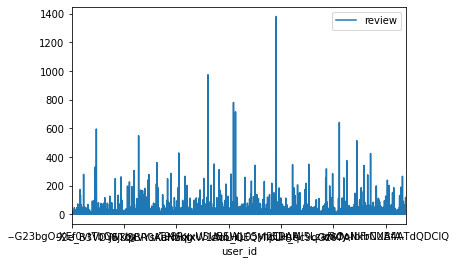

In [ ]:
df_aux.groupby('user_id')[['review']].count().plot() #some of our clients are really active (they have writen several reviews), perhaps we should cross their importance ???

In [ ]:
clients_of_interest = df_aux.groupby('user_id')[['review']].count()
clients_of_interest = clients_of_interest[clients_of_interest.review>100]
clients_of_interest.sort_values('review', ascending=False).head(4) #those who go frequently to restaurants (and have also tried our own)

,review
user_id,
bLbSNkLggFnqwNNzzq-Ijw,1381
PKEzKWv_FktMm2mGPjwd0Q,974
U4INQZOPSUaj8hMjLlZ3KA,781
UYcmGbelzRa0Q6JqzLoguw,715


In [ ]:
print("Clients of interest: {}".format(clients_of_interest.size)) #remember all these visits don't take into account the ones they had with us

Clients of interest: 137


##### One close look at the average rating these two groups give might serve us as benchmark for our own later

In [ ]:
df_aux[df_aux.user_id.isin(clients_of_interest.index)].rating.describe() #confronting with the stat from previously, these client play a major role in the overall evaluation 
#they concentrate a lot of power over the means and std
#they find LA restaurants to be up to thei tastes given an average 3.78/5 to the ones they have been to. 
#Althought the std deviation is kind high, showing they have some taste and are not "easily amused"

count    67820.000000
mean         3.780212
std          1.075607
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

In [ ]:
df_hic = df_aux[df_aux.user_id.isin(clients_of_interest.index)]
np.corrcoef(df_hic.groupby('user_id')[['rating']].mean().rating.values,df_hic.groupby('user_id')[['rating']].count().rating.values) 
#apparently no interenting correlation between those whoe go out more frequently and the rating they give

array([[ 1.        , -0.02240656],
       [-0.02240656,  1.        ]])

In [ ]:
#we can look as well how much their review has influenced other people.
print("{} other clients influenced by this group".format(int(df_hic.useful_review.sum())))
df_hic.useful_review.describe() #few of the are really of great importance, having influence over people

241430 other clients influenced by this group


count    67820.000000
mean         3.559864
std          5.877412
min          0.000000
25%          0.000000
50%          2.000000
75%          4.000000
max        107.000000
Name: useful_review, dtype: float64

In [ ]:
#let's see the most important reviews here
df_hic[df_hic.useful_review>4].rating.describe() #they are very active when coming to reviewing restaurants but are not necessarily more exigent

count    16110.000000
mean         3.756238
std          1.073029
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

In [ ]:
#we can look as well how much they influence other people.
print("{} other clients influenced by this group".format(int(df_hic.useful_user.sum())))
df_hic.useful_user.describe() #few of the are really of great importance, having influence over people

276184769 other clients influenced by this group


count    67820.000000
mean      4072.320392
std       8502.722151
min          0.000000
25%        190.000000
50%        920.000000
75%       3404.000000
max      89792.000000
Name: useful_user, dtype: float64

In [ ]:
#let's see who are the "influencers" here
df_hic[df_hic.useful_user>3500].rating.describe() #they are very active when coming to reviewing restaurants but are not necessarily more exigent

count    16471.000000
mean         3.736689
std          0.954745
min          1.000000
25%          3.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: rating, dtype: float64

In [ ]:
influencers = df_hic[df_hic.useful_user>3500].user_id
print("{} Influencers in LA".format(len(set(influencers)))) #and they have already been to our restaurant!!

153 Influencers in LA


### Moving on to the concunrrence: 
now we will look to business instead of customers

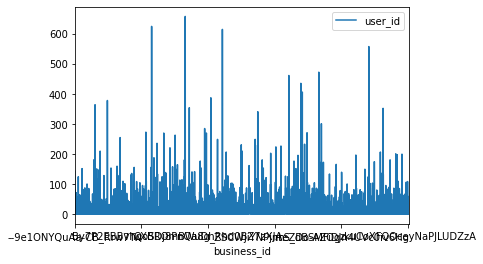

In [ ]:
#lets take a look if we have competitors
df_aux.groupby('business_id')[['user_id']].count().plot() ##some restaurants have really gained the attention of our clientele (several spikes)

In [ ]:
concurrents = set(df_aux.business_id.values)
len(concurrents) #quiet a lot actually, seems like our clientele tries to several different places

5020

In [ ]:
df_concurrents = df_aux.groupby('business_id')
df_concurrents.rating.describe()

,count,mean,std,min,25%,50%,75%,max
business_id,,,,,,,,
--9e1ONYQuAa-CB_Rrw7Tw,143.0,4.195804,0.966034,1.0,4.00,4.0,5.00,5.0
--q7kSBRb0vWC8lSkXFByA,1.0,4.000000,NaN,4.0,4.00,4.0,4.00,4.0
-0BxAGlIk5DJAGVkpqBXxg,4.0,3.750000,1.500000,2.0,2.75,4.0,5.00,5.0
-0RkJ_uIduNLWQrphbADRw,8.0,3.375000,1.407886,1.0,2.75,3.5,4.25,5.0
-1m9o3vGRA8IBPNvNqKLmA,17.0,4.235294,0.903425,2.0,4.00,4.0,5.00,5.0
...,...,...,...,...,...,...,...,...
zwNC-Ow4eIMan2__bS9-rg,42.0,3.976190,1.070402,1.0,4.00,4.0,5.00,5.0
zwddv6HjTjDx9fOr3MFtwQ,6.0,2.333333,1.366260,1.0,1.25,2.0,3.50,4.0
zwmKWhyyV-zejEUbQzBtHw,3.0,4.000000,0.000000,4.0,4.00,4.0,4.00,4.0


In [ ]:
df_concurrents.count().sort_values('review', ascending = False)[['review']].head(10) #10 most visited, (perhaps learn with them?)

,review
business_id,
K7lWdNUhCbcnEvI0NhGewg,657
DkYS3arLOhA8si5uUEmHOw,624
RESDUcs7fIiihp38-d6_6g,614
rcaPajgKOJC2vo_l3xa42A,557
iCQpiavjjPzJ5_3gPD5Ebg,472
cYwJA2A6I12KNkm2rtXd5g,461
eoHdUeQDNgQ6WYEnP2aiRw,435
f4x1YBxkLrZg652xt2KR5g,406
P7pxQFqr7yBKMMI2J51udw,387


In [ ]:
df_concurrents[['review']].count()[df_concurrents[['review']].count().review>387].sum() #they answer for visits

review    4226
dtype: int64

In [ ]:
# clients_of_interest = df_aux.groupby('user_id')[['review']].count()
# clients_of_interest = clients_of_interest[clients_of_interest.review>100]
concurrence=df_concurrents[['review']].count()[df_concurrents[['review']].count().review>387].index
len(concurrence)

8

In [ ]:
df[df.business_id.isin(concurrence)].groupby('name_restaurant')[['rating']].mean()

,rating
name_restaurant,
Bacchanal Buffet,3.776261
Bouchon,4.012207
Earl of Sandwich,4.278717
Gordon Ramsay BurGR,3.894709
Hash House A Go Go,3.919446
Secret Pizza,4.142266
Serendipity 3,3.067898
Wicked Spoon,3.691593


###### should we be careful with the intersections?! If our recommendations are group oriented, then we shoudn't have to worry.

### Make sure we forget no one! Let's go back and analyse in vegas the clients we never had :) 

In [ ]:
df_not_client = df[~df.user_id.isin(clients_restau)]
df_not_client.head(2)

,review_id,review,rating,binary_target,user_id,business_id,useful_review,funny_review,cool_review,name_restaurant,address,city,state,postal_code,latitude,longitude,review_count_restaurant,is_open,name_user,review_count_user,yelping_since,useful_user,funny_user,cool_user,elite,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_photos,is_na
1,2,The food is always good and the prices are rea...,4.0,1,3CJUJILq7CLHk_9OrvpvQg,I4Nr-MVc26qWr08-S3Q1ow,0.0,0.0,0.0,Greenberg's Deli,3790 Las Vegas Blvd S,Las Vegas,NV,89136.0,36.102379,-115.174547,333.0,1.0,Ralph,54.0,2014-03-26 00:29:39,27.0,2.0,4.0,NaN,0.0,3.05,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
2,3,Pick any meat on the planet and the chef will ...,5.0,1,2mxBNBeFrgDszqGS5tdEHA,d_L-rfS1vT3JMzgCUGtiow,0.0,0.0,0.0,Border Grill,3950 S Las Vegas Blvd,Las Vegas,NV,89119.0,36.090067,-115.176973,1623.0,1.0,Nareh,24.0,2013-09-06 16:55:36,14.0,4.0,6.0,NaN,0.0,4.68,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1


#### Those who visited restaurants that are near us might bring up some relevant informations about our nearby rivals and are probably potential clients

In [ ]:
#Initialize DataFrame

#New point Reno 39.53,-119.81
newlat=df_test.latitude.values[0]
newlon=df_test.longitude.values[0]

#Import trig stuff from math
from math import sin, cos, sqrt, atan2,radians

#Distance function between two lat/lon
def getDist(lat1,lon1,lat2,lon2):
  R = 6373.0

  lat1 = radians(lat1)
  lon1 = radians(lon1)
  lat2 = radians(lat2)
  lon2 = radians(lon2)

  dlon = lon2 - lon1
  dlat = lat2 - lat1

  a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1 - a))

  return R * c

#Apply distance function to dataframe
df_not_client['dist']=list(map(lambda k: getDist(df_not_client.loc[k]['latitude'],df.loc[k]['longitude'],newlat,newlon), df_not_client.index))

#This will give all locations within radius of 600 km
df_nc_near = df_not_client[df_not_client['dist']<600]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### Those who visited restaurants far away might not be so relevant in an initial approach

# 2. Data Split

In [ ]:
df_train, df_val = train_test_split(
    df, 
    test_size=0.2, 
    random_state=0, 
    stratify=df['binary_target']
)

# 3. Cleaning

In [ ]:
import nltk
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

In [ ]:
from string import punctuation

from nltk.corpus import stopwords

from nltk.tokenize import RegexpTokenizer
from nltk import wordpunct_tokenize

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

stopw = set(stopwords.words('english'))

# Lowercase
def convert_text_to_lowercase(df, colname):
    df[colname] = df[colname].str.lower()
    return df
    
# Remove punctuation
def remove_punctuation(df,colname):

    def without_punctuation(text):
      return ''.join([c for c in text if c not in punctuation])

    df[colname] = df[colname].apply(lambda review: without_punctuation(review))
    return df

# Tokenize
def tokenize(df,colname):

    tokenizer = RegexpTokenizer(r'\w+')
    df[colname] = df[colname].apply(lambda review: tokenizer.tokenize(review))
    return df

# Remove stopwords - low predictive power
def remove_stopwords(df, colname):

    def without_stopwords(token):
      return [w for w in token if w not in stopw]

    df[colname] = df[colname].apply(lambda review: without_stopwords(review))
    return df

# Remove 1-character words
def remove_1char_words(df, colname):
  
    def without_1char_words(token):
      # return [w for w in token if len(w)>1]
      return ' '.join([w for w in token if len(w)>1])

    df[colname] = df[colname].apply(lambda review: without_1char_words(review))
    return df

# Remove non-alpha
def remove_non_alpha_words(df, colname):
  
    def without_non_alpha_words(text):
      return ' '.join([w for w in text.split() if w.isalpha()])

    df[colname] = df[colname].apply(lambda review: without_non_alpha_words(review))
    return df

# Lemmatizing
def lemmatize(df,colname):

    lemmatizer = WordNetLemmatizer()

    def word_lemmatizer(text):
      return ' '.join([lemmatizer.lemmatize(w) for w in text.split()])

    df[colname] = df[colname].apply(lambda review: word_lemmatizer(review))
    return df

# OR Stemming
def stem(df,colname):

    stemmer = PorterStemmer()

    def word_stemmer(text):
      return ' '.join([stemmer.stem(w) for w in text.split()])

    df[colname] = df[colname].apply(lambda review: word_stemmer(review))
    return df


def text_cleaning(df, colname):
    """
    Takes in a string of text, then performs the following:
    1. convert text to lowercase
    2. ??
    """
    df = (
        df.pipe(convert_text_to_lowercase, colname)
        .pipe(remove_punctuation, colname)
        .pipe(tokenize, colname)
        .pipe(remove_stopwords, colname)
        .pipe(remove_1char_words, colname)
        #.pipe(remove_non_alpha_words, colname)

        .pipe(lemmatize, colname)
        #.pipe(stem, colname)
    )
    return df

In [ ]:
df_train_clean = text_cleaning(df_train, 'review')
df_val_clean = text_cleaning(df_val, 'review')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

# 5. Model

In [ ]:
df.columns

Index(['review', 'rating', 'binary_target', 'useful_review', 'funny_review',
       'cool_review', 'review_count_restaurant', 'is_open',
       'review_count_user', 'yelping_since', 'useful_user', 'funny_user',
       'cool_user', 'elite', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_photos'],
      dtype='object')

In [ ]:
# cols_to_use = ['useful_review']
#, 'funny_review',
#        'cool_review', 'review_count_restaurant', 'is_open',
#        'review_count_user', 'yelping_since', 'useful_user', 'funny_user',
#        'cool_user', 'elite', 'fans', 'average_stars', 'compliment_hot',
#        'compliment_more', 'compliment_profile', 'compliment_cute',
#        'compliment_list', 'compliment_note', 'compliment_plain',
#        'compliment_cool', 'compliment_funny', 'compliment_photos']


In [ ]:
x_train = df_train_clean['review']
y_train = df_train_clean['binary_target']

x_val = df_val_clean['review']
y_val = df_val_clean['binary_target']

In [ ]:
aux = [len(x) for x in x_train]

In [ ]:
np.median(aux)

259.0

In [ ]:
np.max(aux)

4672

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
df_train_clean = df_train_clean.assign(
    extension = df_train_clean.review.apply(lambda x:len(x))
)

In [ ]:
x_train = df_train_clean.review
y_train = df_train_clean.binary_target

x_val = df_val_clean.review
y_val = df_val_clean.binary_target

In [ ]:
# from sklearn.linear_model import SGDClassifier

# logit = SGDClassifier(
#                     loss='hinge',
#                     penalty='l2',
#                     alpha=1e-3,
#                     random_state=42,
#                     max_iter=100,
#                     learning_rate='optimal',
#                     tol=None,
#                 )

In [ ]:
Count_Vectorizer = CountVectorizer(max_features=20000)
TFidf_Vectorizer = TfidfVectorizer(stop_words="english",max_features=20000, ngram_range=(1,2), min_df = 5)

logit = LogisticRegression(random_state=0, max_iter=500, n_jobs = -1, C = 10)
#text_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
pipeline = Pipeline([
    #('vectorizer', Count_Vectorizer),
    ('vectorizer', TFidf_Vectorizer),
    #('model', text_classifier)
    ('model', logit)
    ])

pipeline.fit(x_train, y_train)

y_pred = pipeline.predict(x_val)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[ 69178  13556]
 [  9508 154586]]
              precision    recall  f1-score   support

           0       0.88      0.84      0.86     82734
           1       0.92      0.94      0.93    164094

    accuracy                           0.91    246828
   macro avg       0.90      0.89      0.89    246828
weighted avg       0.91      0.91      0.91    246828



In [ ]:
df_test_cleaned = text_cleaning(df_test, 'review')
x_test = df_test_cleaned['review']
predictions = pipeline.predict(x_test)

soumission = pd.DataFrame({"review_id": df_test['review_id'], "prediction": predictions})
soumission['prediction'] = soumission['prediction'].astype('bool')
soumission['review_id'] = soumission['review_id'].astype('str')

soumission.head().dtypes

soumission.to_csv('/content/drive/My Drive/Hackathon-Capgemini/submissions/submission_fts.csv', index=False)
!kaggle competitions submit -c restaurants-ratings-prediction -f /content/drive/My\ Drive/Hackathon-Capgemini/submissions/submission_fts.csv -m "Second submission"


100% 110k/110k [00:03<00:00, 36.2kB/s]
Successfully submitted to Hackathon Supaero - Restaurants ratings prediction

## GRIDSEARCH

In [ ]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from time import time
from sklearn.model_selection import KFold

X = x_train
y = y_train

tfidf = TfidfVectorizer(max_features=20000,stop_words= "english", analyzer='word', strip_accents = 'ascii')

logit = LogisticRegression(random_state=0, max_iter=500)

pipeline = Pipeline([
    ('vectorizer', tfidf),
    ('model', logit)])
pipeline.fit(X, y)
print('done simple fit')

parameters = {
   'vectorizer__ngram_range': [(1, 2), (1, 3), (2, 2)],
   'vectorizer__min_df': [10,20,100],
   'vectorizer__max_df':[40000, 4000,400],

   'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
   'model__class_weight':[{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}],
   'model__solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(pipeline, parameters, 
                        cv=list(KFold(n_splits=2, shuffle=True).split(X)),
                        n_jobs=-1,verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(X, y)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_

y_pred = pipeline.predict(x_val)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))


df_test_cleaned = text_cleaning(df_test, 'review')
x_test = df_test_cleaned['review']
predictions = pipeline.predict(x_test)
soumission = pd.DataFrame({"review_id": df_test['review_id'], "prediction": y_pred_test})

soumission['prediction'] = soumission['prediction'].astype('bool')
soumission['review_id'] = soumission['review_id'].astype('str')

soumission.head().dtypes

soumission.to_csv('/content/drive/My Drive/Hackathon-Capgemini/submissions/submission_fts.csv', index=False)
!kaggle competitions submit -c restaurants-ratings-prediction -f /content/drive/My\ Drive/Hackathon-Capgemini/submissions/submission_fts.csv -m "Second submission"

done simple fit
Performing grid search...
pipeline: ['vectorizer', 'model']
parameters:
{'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
 'model__class_weight': [{0: 0.5, 1: 0.5},
                         {0: 0.6, 1: 0.4},
                         {0: 0.4, 1: 0.6},
                         {0: 0.3, 1: 0.7}],
 'model__solver': ['liblinear', 'saga'],
 'vectorizer__max_df': [40000, 4000, 400],
 'vectorizer__min_df': [10, 20, 100],
 'vectorizer__ngram_range': [(1, 2), (1, 3), (2, 2)]}
Fitting 2 folds for each of 1296 candidates, totalling 2592 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
exception calling callback for <Future at 0x7fe3f85259e8 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/usr/local/lib/python3.6/dist-packages/joblib/parallel.py", line 340, in __call__
    self.parallel.dispatch_next()
  File "/usr/local/lib/python3.6/dist-packages/joblib/parallel.py", line 769, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/usr/local/lib/python3.6/dist-packages/joblib/parallel.py", line 835, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/joblib/parallel.py", line 754, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/joblib/_parallel_backends.py", line 551, in apply_async
 

TerminatedWorkerError: ignored

## Vectorization & model initiation

## Model fit on train set

# 6. Evaluation

In [ ]:
X_final_train = pd.DataFrame({'y_pred_train_TFidf': y_pred_train_TFidf})
X_final_train['y_pred_train_MLPR'] = y_pred_train_MLPR
X_final_train.head(5)

,y_pred_train_TFidf,y_pred_train_MLPR
0,1,2.689369
1,1,3.040268
2,0,5.506845
3,1,2.655809
4,1,2.724503


# 7. Prediction on test set

In [ ]:
df_test_cleaned = text_cleaning(df_test, 'review')
x_test = df_test_cleaned['review']
predictions = pipeline.predict(x_test)
soumission = pd.DataFrame({"review_id": df_test['review_id'], "prediction": y_pred_test})

soumission['prediction'] = soumission['prediction'].astype('bool')
soumission['review_id'] = soumission['review_id'].astype('str')

soumission.head().dtypes

soumission.to_csv('/content/drive/My Drive/Hackathon-Capgemini/submissions/submission_fts.csv', index=False)
!kaggle competitions submit -c restaurants-ratings-prediction -f /content/drive/My\ Drive/Hackathon-Capgemini/submissions/submission_fts.csv -m "Second submission"

In [ ]:
df_test_cleaned = text_cleaning(df_test, 'review')
x_test = df_test_cleaned['review']

In [ ]:
predictions = pipeline.predict(x_test)

# 8. Formatting & export to csv

In [ ]:
soumission = pd.DataFrame({"review_id": df_test['review_id'], "prediction": y_pred_test})

soumission['prediction'] = soumission['prediction'].astype('bool')
soumission['review_id'] = soumission['review_id'].astype('str')

soumission.head().dtypes

soumission.to_csv('/content/drive/My Drive/Hackathon-Capgemini/submissions/submission_miguel2.csv', index=False)

KeyError: ignored

# 9. Model Interpretability - Do not consider for kaggle competition

In [ ]:
class_names = [0, 1]
explainer = LimeTextExplainer(class_names=class_names)

def lime_model_interpreter(clf, idx, n_features):
    text_idx = x_val.iloc[idx]
    target_idx = y_val.iloc[idx]

    exp = explainer.explain_instance(text_idx, clf.predict_proba, num_features=n_features)
    print('Document id: %d' % idx)
    print('Probability(True) =', clf.predict_proba([text_idx])[0,1])
    print('True class: %s' % class_names[target_idx])

    exp.show_in_notebook(text=True)

In [ ]:
lime_model_interpreter(pipeline, 2, n_features=6) 

NameError: name 'x_val' is not defined

In [ ]:
lime_model_interpreter(pipeline, 7, n_features=6) 

NameError: name 'x_val' is not defined